## Сжатие картинок с помощью SVD разложения

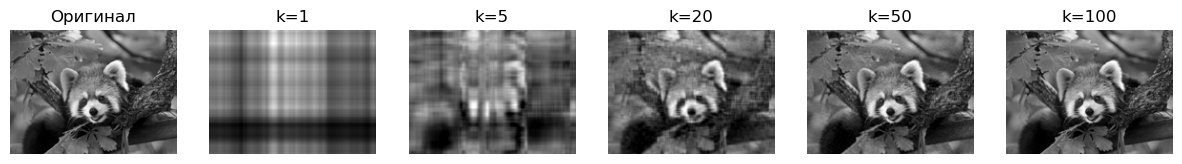

In [23]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

img = Image.open('panda.jpg').convert("L")
w, h = img.size
img = img.resize((w//4, h//4))   # можно не делать .resize(())
# x = np.array(img, dtype=np.float32) # преобразование из PIL в numpy array
# U, S, V = np.linalg.svd(X, full_matrices=False) # разложение SVD
# # обратное преобразование из numpy array в PIL с сохранение изображения на диск
# Image.fromarray(np.asarray(Y_r, dtype=np.uint8)).save(f'{r}.png')
X = np.array(img, dtype=np.float32)
U, S, Vt = np.linalg.svd(X, full_matrices=False)

def restore_image(U, S, Vt, k):
    return (U[:, :k] * S[:k]) @ Vt[:k, :]
ks = [1, 5, 20, 50, 100]
fig, axes = plt.subplots(1, len(ks)+1, figsize=(15, 6))

axes[0].imshow(X, cmap="gray")
axes[0].set_title("Оригинал")
axes[0].axis("off")

for i, k in enumerate(ks):
    Xk = restore_image(U, S, Vt, k)
    Xk = np.clip(Xk, 0, 255) 
    axes[i+1].imshow(Xk.astype(np.uint8), cmap="gray")
    axes[i+1].set_title(f"k={k}")
    axes[i+1].axis("off")

plt.show()

## Гауссово распределение, линейный дискриминантный анализ и наивный байес

### 1. Многомерное гауссово распределение

Ковариационная матрица после поворота:
 [[ 0.10468578 -0.09981547]
 [-0.09981547  0.11201982]]


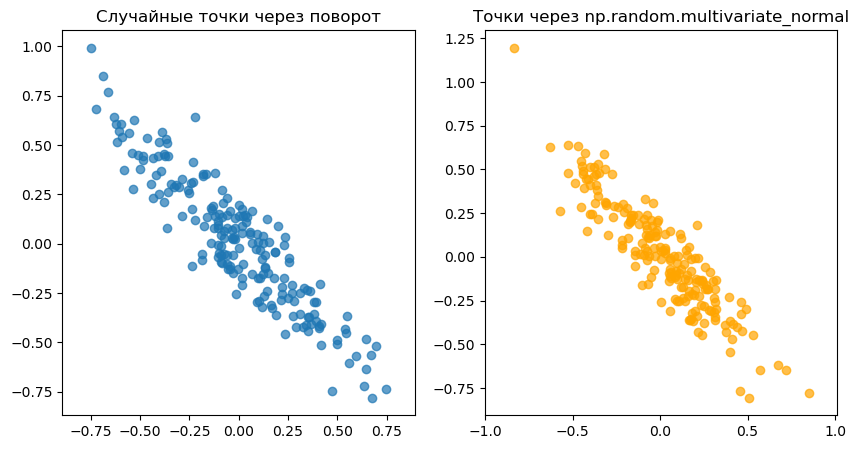

In [29]:
import matplotlib.pyplot as plt
import numpy as np
M = 200
sigma1 = 0.1
sigma2 = 0.5
alpha = np.pi / 4  

x1 = np.random.randn(M, 1) * sigma1
x2 = np.random.randn(M, 1) * sigma2

X = np.concatenate((x1, x2), axis=1)

R = np.array([[np.cos(alpha), -np.sin(alpha)],
              [np.sin(alpha),  np.cos(alpha)]])

X_rot = X @ R.T 

cov_matrix = np.cov(X_rot, rowvar=False)
print("Ковариационная матрица после поворота:\n", cov_matrix)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.scatter(X_rot[:,0], X_rot[:,1], alpha=0.7)
plt.title("Случайные точки через поворот")
plt.axis("equal")

mean = [0, 0]
cov = cov_matrix 
X_mv = np.random.multivariate_normal(mean, cov, M)

plt.subplot(1,2,2)
plt.scatter(X_mv[:,0], X_mv[:,1], alpha=0.7, color='orange')
plt.title("Точки через np.random.multivariate_normal")
plt.axis("equal")

plt.show()

### 2. Плотность вероятности гауссового распределения

Среднее:
 [-0.02086222  0.01535182]
Ковариационная матрица:
 [[ 0.12962533 -0.11949862]
 [-0.11949862  0.13050296]]


C:\Users\Pelageya\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


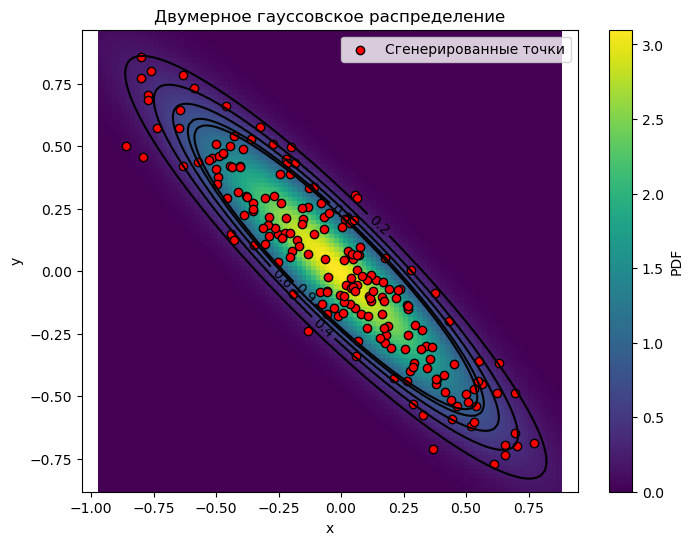

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

M = 200
sigma1 = 0.1
sigma2 = 0.5
alpha = np.pi / 4  

x1 = np.random.randn(M, 1) * sigma1
x2 = np.random.randn(M, 1) * sigma2
X = np.concatenate((x1, x2), axis=1)

R = np.array([[np.cos(alpha), -np.sin(alpha)],
              [np.sin(alpha),  np.cos(alpha)]])
X_rot = X @ R.T

mu = X_rot.mean(axis=0)
C = np.cov(X_rot, rowvar=False)
print("Среднее:\n", mu)
print("Ковариационная матрица:\n", C)

xx = np.linspace(X_rot[:,0].min()-0.1, X_rot[:,0].max()+0.1, 100)
yy = np.linspace(X_rot[:,1].min()-0.1, X_rot[:,1].max()+0.1, 100)
XX, YY = np.meshgrid(xx, yy)
points = np.stack((XX.flatten(), YY.flatten()), axis=1)

mvn = multivariate_normal(mean=mu, cov=C)
ZZ = mvn.pdf(points).reshape(XX.shape)

plt.figure(figsize=(8,6))

img = plt.pcolor(XX, YY, ZZ, shading='auto', cmap='viridis')
plt.colorbar(img, label='PDF')

CS = plt.contour(XX, YY, ZZ, levels=[0.2, 0.4, 0.6, 0.8, 0.9], colors='k')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(X_rot[:,0], X_rot[:,1], c='red', edgecolor='k', label='Сгенерированные точки')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Двумерное гауссовское распределение')
plt.legend()
plt.axis('equal')
plt.show()

### 3. Бинарная классификация

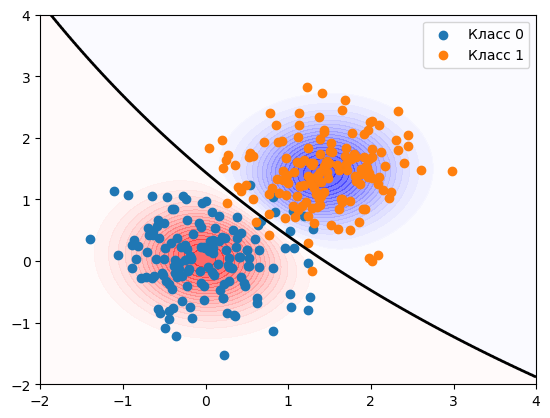

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(0)
N = 150

params = [
    ([0, 0], [[0.3, 0], [0, 0.3]]),
    ([1.5, 1.5], [[0.3, 0], [0, 0.3]])
]

data = [np.random.multivariate_normal(mu, cov, N) for mu, cov in params]
mus = [d.mean(axis=0) for d in data]
covs = [np.cov(d, rowvar=False) for d in data]
ps = [len(d)/(2*N) for d in data]

xx, yy = np.meshgrid(np.linspace(-2, 4, 200), np.linspace(-2, 4, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

pdf0 = multivariate_normal(mus[0], covs[0]).pdf(grid)
pdf1 = multivariate_normal(mus[1], covs[1]).pdf(grid)
diff = (pdf0*ps[0] - pdf1*ps[1]).reshape(xx.shape)

plt.contourf(xx, yy, diff, levels=50, cmap="bwr", alpha=0.6)
plt.contour(xx, yy, diff, levels=[0], colors="k", linewidths=2)
for i, d in enumerate(data):
    plt.scatter(d[:,0], d[:,1], label=f"Класс {i}")
plt.legend()
plt.show()

### 4. LDA (linear discriminant analysis)

In [38]:
import numpy as np
from sklearn.base import BaseEstimator

class myLDA(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        X0, X1 = X[y==0], X[y==1]
        
        self.mu0 = X0.mean(axis=0)
        self.mu1 = X1.mean(axis=0)
        
        cov0 = np.cov(X0, rowvar=False)
        cov1 = np.cov(X1, rowvar=False)
        self.cov = (cov0*(len(X0)-1) + cov1*(len(X1)-1)) / (len(X)-2)
       
        self.inv_cov = np.linalg.inv(self.cov)
        
        self.p0 = len(X0)/len(X)
        self.p1 = len(X1)/len(X)
        return self
    
    def decision_function(self, X):
        def g(x, mu, p):
            return x @ self.inv_cov @ mu - 0.5 * mu @ self.inv_cov @ mu + np.log(p)
        
        g0 = np.apply_along_axis(lambda xx: g(xx, self.mu0, self.p0), 1, X)
        g1 = np.apply_along_axis(lambda xx: g(xx, self.mu1, self.p1), 1, X)
        return g1 - g0  
    
    def predict(self, X):
        return (self.decision_function(X) > 0).astype(int)

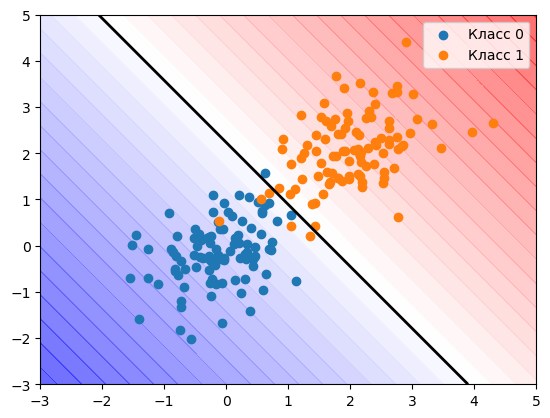

In [40]:
import matplotlib.pyplot as plt

np.random.seed(1)
X0 = np.random.multivariate_normal([0,0], [[0.5,0.2],[0.2,0.5]], 100)
X1 = np.random.multivariate_normal([2,2], [[0.5,0.2],[0.2,0.5]], 100)

X = np.vstack([X0,X1])
y = np.array([0]*len(X0) + [1]*len(X1))

clf = myLDA().fit(X,y)

xx, yy = np.meshgrid(np.linspace(-3,5,200), np.linspace(-3,5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf.decision_function(grid).reshape(xx.shape)

plt.contourf(xx,yy,zz,levels=50,cmap="bwr",alpha=0.6)
plt.contour(xx,yy,zz,levels=[0],colors="k",linewidths=2) 
plt.scatter(X0[:,0],X0[:,1],label="Класс 0")
plt.scatter(X1[:,0],X1[:,1],label="Класс 1")
plt.legend()
plt.show()

### 5. Наивный байесовый классификатор (NaiveBayes)

In [43]:
import numpy as np
from sklearn.base import BaseEstimator

class myNB(BaseEstimator):
    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes, n_features = len(self.classes), X.shape[1]
        self.means = np.zeros((n_classes, n_features))
        self.vars = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)

        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.means[i] = X_c.mean(axis=0)
            self.vars[i] = X_c.var(axis=0) + 1e-6
            self.priors[i] = X_c.shape[0] / X.shape[0]
        return self

    def _gaussian_density(self, i, x):
        return np.exp(- (x - self.means[i])**2 / (2 * self.vars[i])) / np.sqrt(2 * np.pi * self.vars[i])

    def predict(self, X):
        y_pred = []
        for x in X:
            post = [np.log(self.priors[i]) + np.sum(np.log(self._gaussian_density(i, x))) 
                    for i in range(len(self.classes))]
            y_pred.append(self.classes[np.argmax(post)])
        return np.array(y_pred)

### 6. Сравнение двух алгоритмов: LDA и NB

In [46]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X, y = make_classification(
    n_samples=1000,
    n_features=5,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

lda_model = LDA()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_test)

def evaluate(y_true, y_pred, name):
    print(f"\n{name}:")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))

evaluate(y_test, y_pred_nb, "Naive Bayes")
evaluate(y_test, y_pred_lda, "LDA")


Naive Bayes:
Accuracy : 0.93
Precision: 0.9221556886227545
Recall   : 0.9506172839506173

LDA:
Accuracy : 0.91
Precision: 0.9411764705882353
Recall   : 0.8888888888888888
